## Unbalanced Gromov-Wasserstein for SNARE-seq example

To simulate imbalance between cell types, we subsample the ATAC dataset and try to align to the full RNA dataset.

First import the data:

In [1]:
import numpy as np
from sklearn.preprocessing import normalize
#load the data:
Xrna=normalize(np.load("../data/SNARE/SNAREseq_rna_feat.npy"))
Yatac=normalize(np.load("../data/SNARE/SNAREseq_atac_feat.npy"))
print("Dimensions of input datasets are: ", "X(rna)= ", Xrna.shape, " Y(atac)= ", Yatac.shape)

Dimensions of input datasets are:  X(rna)=  (1047, 10)  Y(atac)=  (1047, 19)


Visualize the distribution of cell-types:

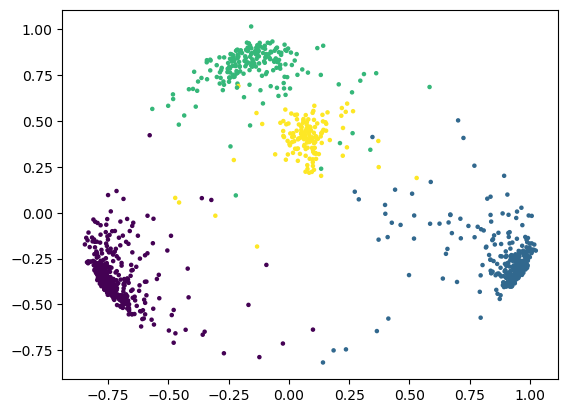

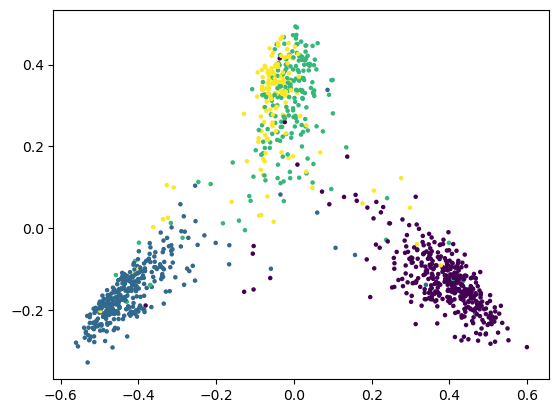

In [2]:
Xrna_ctypes=np.loadtxt("../data/SNARE/SNAREseq_rna_types.txt").astype(int)
Yatac_ctypes=np.loadtxt("../data/SNARE/SNAREseq_atac_types.txt").astype(int)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
pca=PCA(n_components=2)
Xrna_2Dpca=pca.fit_transform(Xrna)
Yatac_2Dpca=pca.fit_transform(Yatac)

plt.scatter(Xrna_2Dpca[:,0], Xrna_2Dpca[:,1], s=5, c=Xrna_ctypes)
plt.show()
plt.scatter(Yatac_2Dpca[:,0], Yatac_2Dpca[:,1], s=5, c=Yatac_ctypes)
plt.show()



Randomly subsample different cell types in the ATAC domain for the "unbalanced" experiment

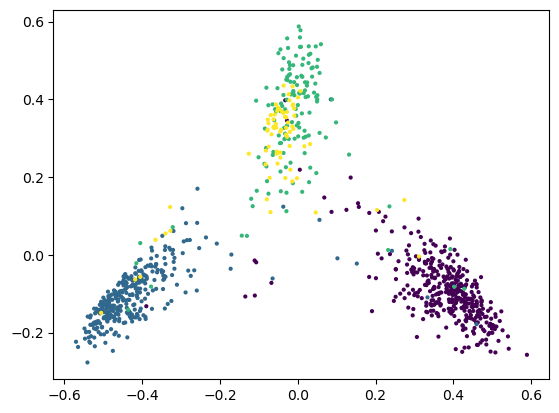

In [3]:
props = [1, 1, 0.7, 0.5]

index = np.concatenate([np.where(Yatac_ctypes == i)[0][0:int((Yatac_ctypes == i).sum() * props[i-1])] for i in range(1,len(props)+1)])
Yatac_subsamp = Yatac[index, :]

Yatac_subsamp_2Dpca = pca.fit_transform(Yatac_subsamp)
plt.scatter(Yatac_subsamp_2Dpca[:, 0], Yatac_subsamp_2Dpca[:, 1], s = 4, c = Yatac_ctypes[index])

### Now run SCOTv2 to align the RNA domain with the subsampled ATAC domain

In [4]:
import os
os.chdir("../src")
import scotv2
SCOTv2=scotv2.SCOTv2([Xrna, Yatac_subsamp])
integrated_data=SCOTv2.align(normalize=False, k=110, eps=5e-3, rho=0.01,projMethod="barycentric")

computing intra-domain graph distances
running pairwise dataset alignments
Unbalanced GW step: 0
Unbalanced GW step: 10
FLAGS [True]


(1047, 10) (914, 10)
(1047, 2) (914, 2)


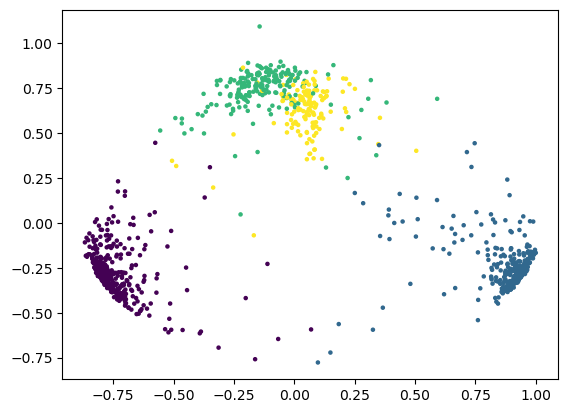

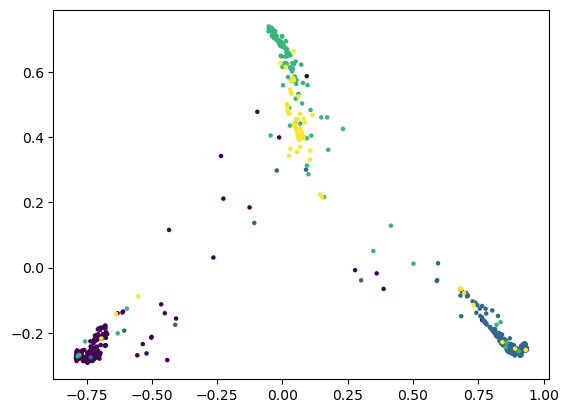

In [5]:
Xrna_integrated=integrated_data[0]
Yatac_subsamp_integrated=integrated_data[1]
#run PC jointly:
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)
concatenated_pc=pca.fit_transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

print(Xrna_integrated.shape, Yatac_subsamp_integrated.shape)
print(Xrna_integrated_pc.shape, Yatac_subsamp_integrated_pc.shape)

plt.scatter(Xrna_integrated_pc[:,0], Xrna_integrated_pc[:,1], s=5, c=Xrna_ctypes)
plt.show()
plt.scatter(Yatac_subsamp_integrated_pc[:,0], Yatac_subsamp_integrated_pc[:,1], s=5, c=Yatac_ctypes[index])
plt.show()

Compare with SCOTv1:

In [6]:
import scotv1
SCOTv1=scotv1.SCOT(Xrna, Yatac_subsamp)
Xrna_aligned, Yatac_sumsamp_aligned=SCOTv1.align(k=110, e=5e-3, normalize=False, XontoY=False)

It.  |Err         
-------------------
    0|8.740201e-04|
   10|4.616616e-05|
   20|7.293192e-06|
   30|2.832572e-06|
   40|9.805220e-07|
   50|3.238584e-07|
   60|1.052573e-07|
   70|3.402871e-08|
   80|1.098225e-08|
   90|3.542382e-09|
  100|1.142409e-09|
  110|3.684024e-10|


(1047, 2) (914, 2)


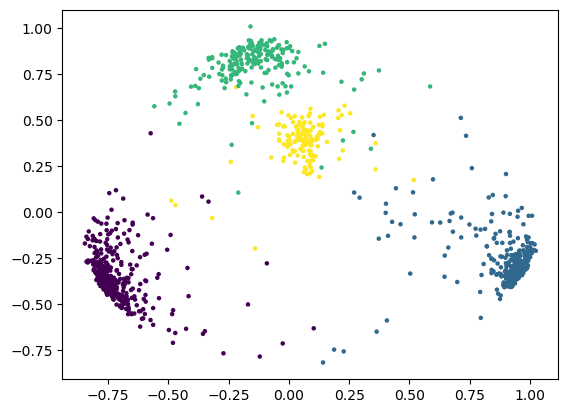

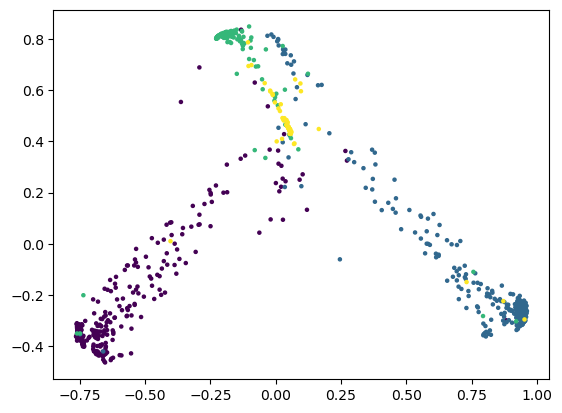

In [7]:
#run PCA jointly:
concatenated=np.concatenate((Xrna_aligned,Yatac_sumsamp_aligned), axis=0)
concatenated_pc=pca.fit_transform(concatenated)
Xrna_aligned_pc=concatenated_pc[0:Xrna_aligned.shape[0],:]
Yatac_sumsamp_aligned_pc=concatenated_pc[Xrna_aligned.shape[0]:,:]

print(Xrna_aligned_pc.shape, Yatac_sumsamp_aligned_pc.shape)

plt.scatter(Xrna_aligned_pc[:,0], Xrna_aligned_pc[:,1], s=5, c=Xrna_ctypes)
plt.show()
plt.scatter(Yatac_sumsamp_aligned_pc[:,0], Yatac_sumsamp_aligned_pc[:,1], s=5, c=Yatac_ctypes[index])
plt.show()